# Loan Eligibility Prediction


Welcome to the Project on classification. I will be using the credit risk dataset for this problem.

----------------
## Context: 
----------------

Credit risk is the risk of loss resulting from the failure by a borrower to repay the principal and interest owed to the lender. The lender uses the interest payments from the loan to compensate for the risk of potential losses. When the borrower defaults on his/her obligations, it causes an interruption in the cash flow of the lender.

In the banking sector, this is an important factor to be considered before approving the loan of an applicant in order to cushion the lender from loss of cash flow and reduce the severity of losses. 

------------------
## Objective:
------------------

Easy House is a finance company that deals in several varieties of home loans. They have a presence across urban, semi-urban, and rural areas. Currently, the customer first applies for a home loan post which the company validates the customer's eligibility for that loan. 

Now, the company wants to automate the loan eligibility process. They want to harness their past customers' data to build a model to predict whether the loan should be approved or not. This would help the company prevent potential losses, save time and focus more on eligible customers.

--------------------------
## Data Dictionary:
--------------------------

The data contains the following attributes:

* **Loan_ID**: Unique Loan ID
* **Gender**: Gender of the applicant - Male/Female
* **Married**: Whether the applicant is married or not (Yes/No)
* **Dependents**: Number of dependents of the applicant
* **Education**: Applicant's education (Graduate/Not Graduate)
* **Self_Employed**: Whether the applicant is self-employed (Yes/No)
* **ApplicantIncome**: The income of the applicant (\$)
* **CoapplicantIncome**: The co-applicant's income in case of a joint loan and 0 otherwise (\$)
* **LoanAmount**: Loan amount (dollars in thousands) 
* **Loan_Amount_Term**: Term of loan in months
* **Credit_History**: Whether the applicant's credit history meets required guidelines
* **Property_Area**: The area the property pertaining to the loan belongs to - Urban/Semi-Urban/Rural
* **Loan_Status**: Loan approved (1 - Yes, 0 - No)

## Importing necessary libraries and overview of the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#to split the data into train and test data
from sklearn.model_selection import train_test_split
#to build a logistic regression model
from sklearn.linear_model import LogisticRegression

#to build SVM model
from sklearn.svm import SVC

#Metrics to evaluate the model
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

import warnings
warnings.filterwarnings("ignore")

#### Loading data

In [2]:
data = pd.read_csv("CreditRisk.csv")
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,0,360.0,1.0,Urban,1
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128,360.0,1.0,Rural,0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66,360.0,1.0,Urban,1
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120,360.0,1.0,Urban,1
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141,360.0,1.0,Urban,1


#### Check the info of the data

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    int64  
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 62.5+ KB


**Observations:**

- There are 614 observations and 13 columns in the data.
- ApplicantIncome, CoapplicantIncome, Loan_Amount_Term, Credit_History, and Loan_Status are numeric data types. The rest of the variables are of the object data type.
- There are several columns with less than 614 non-null entries i.e. these columns have missing values.
- Loan_ID column is an identifier. Let's check if each entry of the column is unique.

## Exploratory Data Analysis and Data Preprocessing

#### Dropping Loan_ID column

In [4]:
data.drop(columns=['Loan_ID'], inplace=True)

#### Summary Statistics for numerical columns

In [5]:
#Creating a list of numerical columns
num_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

data[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.00,81000.0
CoapplicantIncome,614.0,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,614.0,141.166124,88.340630,0.0,98.0,125.0,164.75,700.0
Loan_Amount_Term,600.0,342.000000,65.120410,12.0,360.0,360.0,360.00,480.0


**Observations:**

- The average income of applicants is about 5.4K dollars. It has a large range of values from 150 to 81,000. It would be interesting to see if low applicant income implies a low loan amount.
- The average co-applicant income is about 1.6K dollars which is much lower than the applicant's income. The 25th percentile value is 0 and the median value is 1,188 dollars which implies that the number of joint home loans is more than the number of non-joint loans.
- The two columns `ApplicantIncome` and `CoapplicantIncome` give the same information i.e. income of applicants. It would be better to have that information in one column only. We can add these two columns to get the total income per application.
- The 25th, 50th, and 75th percentile value of the loan term is 360 months i.e. 30 years. This implies that the majority of home loans in this dataset are for 30 years of term.
- We can convert the scale of the loan term from months to years to make it easier to read.
- The average loan amount is 1.41K dollars. It has a large range of values, which is to be expected. 
- The loan amount has zero values, which is absurd since loan amounts are meant to be non-zero. So we can treat 0's as missing values.

Before imputing the missing values and 0's in `LoanAmount`, let's do some feature engineering and check the distributions, counts, and outliers for different variables.

#### Feature Engineering

In [6]:
#Converting the scale of loan term from months to years
data['Loan_Amount_Term']=data['Loan_Amount_Term']/12

#Adding the applicant and co-applicant income to get the total income per application
data['total_income']=data['ApplicantIncome'] + data['CoapplicantIncome']

In [7]:
#Dropping the columns as we created a new column which captures the same information
data.drop(columns=['ApplicantIncome', 'CoapplicantIncome'], inplace=True)

#### Check the distribution and outliers for each column in the data

LoanAmount
Skew : 2.36


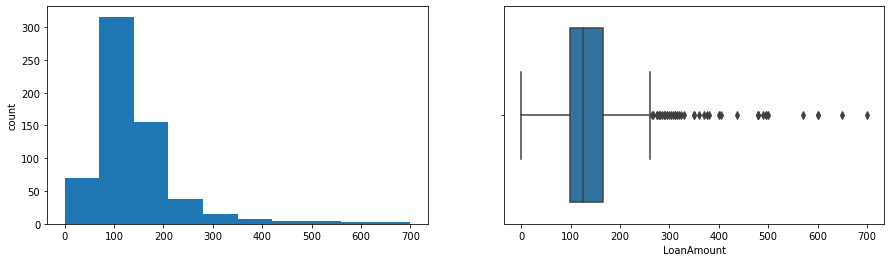

total_income
Skew : 5.63


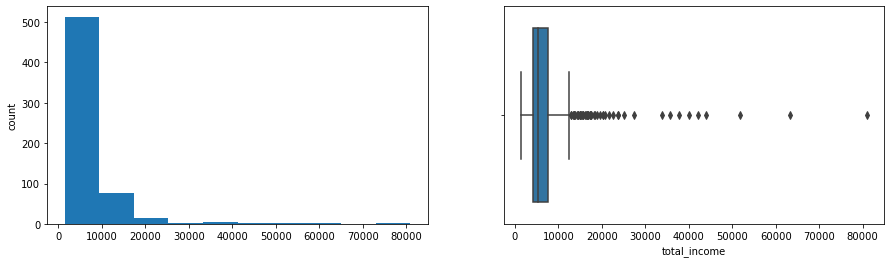

In [8]:
for col in ['LoanAmount', 'total_income']:
    print(col)
    print('Skew :',round(data[col].skew(),2))
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    data[col].hist(bins=10, grid=False)
    plt.ylabel('count')
    plt.subplot(1,2,2)
    sns.boxplot(x=data[col])
    plt.show()

**Observations:**

- Both the variables are highly skewed to the right and have many outliers which can be expected as the data contains different types of areas - Rural, Urban & Semi-Urban. 
- We can observe from the histogram that majority of values for total income are less than 10K.

Not, let's check the percentage of observations in each category for all the categorical variables.

#### Checking percentage of each category for categorical variables

In [9]:
#Creating list of categorical columns
cat_col= ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History','Property_Area', 'Loan_Status']

for col in cat_col:
    print(data[col].value_counts(normalize=True))  #The parameter normalize=True gives the percentage of each category
    print('*'*40)                                  #Print the * 40 times to separate different variables

Male      0.813644
Female    0.186356
Name: Gender, dtype: float64
****************************************
Yes    0.651391
No     0.348609
Name: Married, dtype: float64
****************************************
0     0.575960
1     0.170284
2     0.168614
3+    0.085142
Name: Dependents, dtype: float64
****************************************
Graduate        0.781759
Not Graduate    0.218241
Name: Education, dtype: float64
****************************************
No     0.859107
Yes    0.140893
Name: Self_Employed, dtype: float64
****************************************
1.0    0.842199
0.0    0.157801
Name: Credit_History, dtype: float64
****************************************
Semiurban    0.379479
Urban        0.328990
Rural        0.291531
Name: Property_Area, dtype: float64
****************************************
1    0.687296
0    0.312704
Name: Loan_Status, dtype: float64
****************************************


**Observations:**

- Percentage of male customers (approx 81%) is more than the percentage of female customers (approx 19%).
- About 65% of customers are married. This indicates that married people apply more for the home loan as compared to non-married people.
- The majority of customers have 0 or 1 dependents. Some of these entries are 3+ which means 3 or more dependents. Since we don't know the actual number, we can treat this as a separate category.
- About 78% of customers are graduate. It looks like the majority of customers are educated.
- Only ~14% of customers are self-employed. This indicates that salaried people apply more for the home loan.
- The majority of customers, about 84%, have credit history as per the required guidelines.
- The count of observations is approximately evenly distributed among Urban, Semi-Urban, and Rural areas. This implies that the company has a presence in all kinds of areas.
- The number of home loans approved is comparatively higher than the number of those not approved. About 69% of applied loans get approved. Although we have limited data, the reason for this could either be a fairly lenient attitude from the company towards approving loans OR that many of the customers applying for these home loans are actually eligible for them.

#### Imputing missing values

In [10]:
#Imputing missing values with mode for the categorical variables 
for col in ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History']:
    data[col].fillna(value=data[col].mode()[0], inplace=True)

In [11]:
#Replacing 0's with null values in loan amount 
data.LoanAmount.replace(0, np.nan, inplace=True)

#Imputing null values in loan amount with the median
data.LoanAmount.fillna(value=data.LoanAmount.median(), inplace=True)

**Now that we are done with the data preprocessing. Let's explore the data a bit more with bivariate analysis.**

**Let's check how credit history is related to loan status**

<AxesSubplot:xlabel='Credit_History', ylabel='count'>

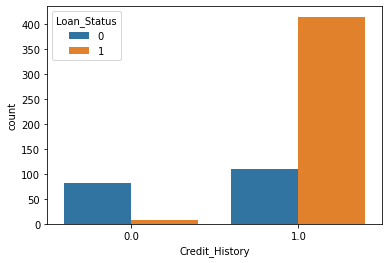

In [12]:
sns.countplot(x=data.Credit_History, hue=data.Loan_Status)

- The plot shows that credit history is an important factor while checking loan eligibility. There are very few customers whose loan was approved even when their credit history did not meet required guidelines.

**Let's check the relationship between education and loan status**

<AxesSubplot:xlabel='Education', ylabel='count'>

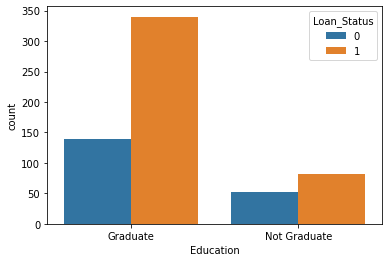

In [13]:
sns.countplot(x=data.Education, hue=data.Loan_Status)

- We can see that graduate customers are more likely to get loans.
- This might be because, in general, graduate customers have higher income when compared to non-graduates. Let's check if this is true.

Let's check how property area is related with loan status

<AxesSubplot:xlabel='Property_Area', ylabel='count'>

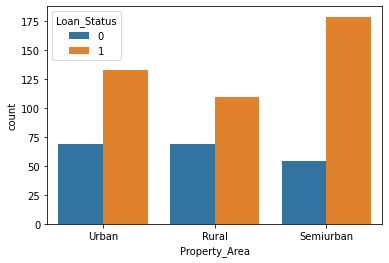

In [14]:
sns.countplot(x=data.Property_Area, hue=data.Loan_Status)

- The plot shows that more loans are approved for properties in semi-urban areas. 
- This could be due to several reasons. The bank might be charging higher interest rates for semi-urban areas or the current customer base of the company from semi-urban areas might actually be more eligible for home loans based on loan applicant features. We cannot be certain as we don't have the data to support this claim.

**Now that we have processed and explored our data, let's prepare it for modeling.**

## Preparing data for modeling

- Models cannot take non-numeric inputs. So, we will first create dummy variables for all the categorical variables.
- We will then split the data into train and test sets.

In [15]:
#Separating target variable and other variables
X=data.drop(columns='Loan_Status')
Y=data['Loan_Status']

In [16]:
#Creating dummy variables 
#drop_first=True is used to avoid redundant variables
X = pd.get_dummies(X, drop_first=True)

In [17]:
#Splitting the data into train and test sets
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.30,random_state=1)

## Building Classification Models

**Before training the model, let's choose the appropriate model evaluation criterion as per the problem on hand.**

### Model evaluation criterion:

#### Since this is a binary classification problem, the model can make wrong predictions in one of two ways:
1. Predicting a customer is not eligible for a loan when the customer actually is eligible - Loss of opportunity
2. Predicting a customer is eligible for a loan when the customer is actually not - Financial loss

#### Which case is more important? 
* Predicting that the customer is eligible when he is not, because the person might default or not be able to return the loan, which would result in financial loss to the company.

#### How to reduce this loss i.e need to reduce False Negatives?
* In classification, the class of interest is considered the positive class. Here, the class of interest is 0 i.e. identifying non-eligible customers. So, the company wants to minimize the number of false negatives, in other words **Recall** is the evaluation criterion to be maximized.

Also, let's create a function to calculate and print the classification report and confusion matrix so that we don't have to rewrite the same code repeatedly for each model.

In [18]:
#function to print classification report and get confusion matrix in a proper format

def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Eligible', 'Eligible'], yticklabels=['Not Eligible', 'Eligible'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

### Logistic Regression

In [19]:
#Fitting the model
log_reg=LogisticRegression(random_state=1)
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=1)

**Let's check the coefficient of each dependent variable in the data**

In [20]:
pd.Series(log_reg.coef_[0], index=X_train.columns).sort_values(ascending=False)

Credit_History             3.026333
Property_Area_Semiurban    0.821630
Married_Yes                0.189433
Dependents_2               0.154752
Dependents_3+              0.113782
total_income              -0.000010
LoanAmount                -0.000475
Property_Area_Urban       -0.006452
Loan_Amount_Term          -0.065878
Self_Employed_Yes         -0.098512
Gender_Male               -0.105990
Dependents_1              -0.145727
Education_Not Graduate    -0.491760
dtype: float64

- The credit history is the most important variable while checking the eligibility for a loan as it has the largest coefficient. As observed earlier, if a customer's credit history meets the required guidelines, then he/she is more likely to get a home loan. 
- `Property_Area_Semiurban` is the second most important variable but `Property_Area_Urban` has a very small coefficient. As observed earlier, customers are more likely to get the loan if their property is situated in semi-urban areas.
- `Education_Not Graduate` has the third highest coefficient (in terms of magnitude). This is aligned with our observation earlier that non-graduate customers are less likely to get a home loan.


**Now, let's check the performance of the model on the training set**

              precision    recall  f1-score   support

           0       0.91      0.44      0.59       131
           1       0.80      0.98      0.88       298

    accuracy                           0.82       429
   macro avg       0.85      0.71      0.74       429
weighted avg       0.83      0.82      0.79       429



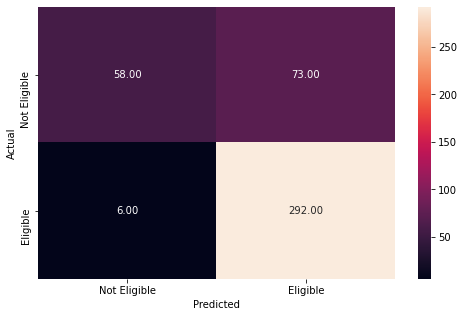

In [21]:
# Checking performance on the training data
y_pred_train = log_reg.predict(X_train)
metrics_score(y_train, y_pred_train)

**Observations:**

- The precision is high but the recall for class 0 is quite low i.e. the model is not able to identify non-eligible customers.
- Accuracy is about 82%. 

              precision    recall  f1-score   support

           0       0.92      0.39      0.55        61
           1       0.77      0.98      0.86       124

    accuracy                           0.79       185
   macro avg       0.85      0.69      0.71       185
weighted avg       0.82      0.79      0.76       185



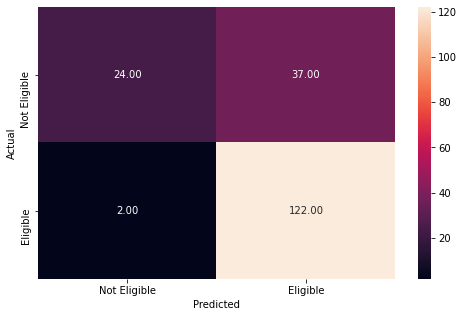

In [22]:
# Checking performance on the test data
y_pred_test = log_reg.predict(X_test)
metrics_score(y_test, y_pred_test)

- Model performance on train and test data seem to be quite same, this signifies that the model is not over fitting and giving a generalized model.

In [23]:
#fitting SVM
svm = SVC(kernel = 'linear')
model = svm.fit(X = X_train, y = y_train)

              precision    recall  f1-score   support

           0       0.94      0.34      0.50       131
           1       0.77      0.99      0.87       298

    accuracy                           0.79       429
   macro avg       0.86      0.67      0.69       429
weighted avg       0.82      0.79      0.76       429



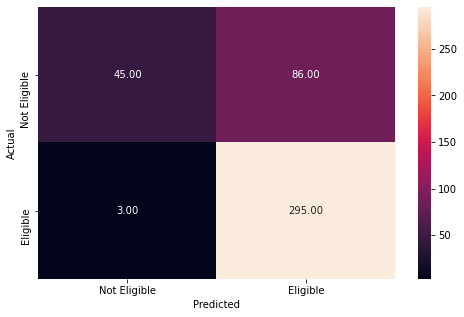

In [24]:
# Checking performance on the training data
y_pred_train_svm = model.predict(X_train)
metrics_score(y_train, y_pred_train_svm)

- SVM is also giving similar results as of logistic regression, with high precession and low recall and about 80% accuracy.

              precision    recall  f1-score   support

           0       0.93      0.23      0.37        61
           1       0.72      0.99      0.84       124

    accuracy                           0.74       185
   macro avg       0.83      0.61      0.60       185
weighted avg       0.79      0.74      0.68       185



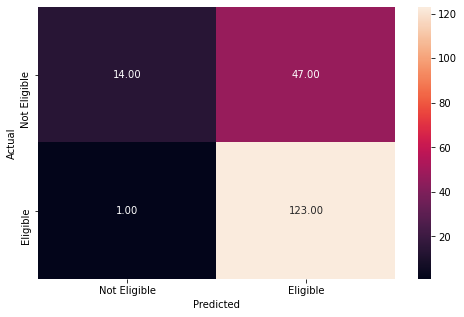

In [25]:
# Checking performance on the test data
y_pred_test_svm = model.predict(X_test)
metrics_score(y_test, y_pred_test_svm)

- SVM model seem to overfit the data a bit, as the recall for th class 0 has reduced to .23 also the accuracy has come down to .74

## Conclusion:

- I have been able to build a classifier to predict non-eligible customers and identified key factors that drive the eligibility process for home loans.
- For the current data, logistic regression is performing better than the SVM classifier. Logistic regression is giving a generalized performance across train and test datasets whereas SVM is overfitting on the training data.


## Recommendations:

- People with a responsible and financially stable background i.e. whose credit history meets the required guidelines are more likely to be eligible for a loan and are a lower risk for the company.
- Applicants with low credit history are more likely to fail to be accepted because they have a high chance of not repaying the loan.
- The borrower's property area is a significant driver i.e. those who live in semi-urban neighborhoods are more likely to get the loan.
- Education is also an important factor while checking the eligibility of a person for the loan. We identified that graduate customers are more likely to get the loan and are a lower risk for the company.